# Titanic: Advanced Modeling with Hyperparameter Tuning, Feature Engineering, and Stacking Ensemble
In this notebook, we will tackle the Titanic problem by applying advanced techniques, including:

Hyperparameter Tuning: Using GridSearchCV to optimize model parameters.
Feature Engineering: Extracting features such as Title, FamilySize, and Deck from the Cabin column; applying log transformation to Fare; and creating interaction variables.
Ensemble Techniques: Implementing a Stacking ensemble with multiple base models (Random Forest, LightGBM, CatBoost, XGBoost) to enhance prediction performance.

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='whitegrid', palette='muted', font_scale=1.2)


In [2]:
# Load train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)

# Show the first 5 rows of the train dataset
train.head()

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Initial Data Exploration
Examining the data structure, missing values, and basic statistical parameters.

In [3]:
# Display dataset information
train.info()

# Convert 'Survived' column to string type
train['Survived'] = train['Survived'].astype('str')

# Display descriptive statistics
train.describe()

# Check for missing values
print("Missing values in each column:")
print(train.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Missing values in each column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Emba

## Data Visualization
Creating some visualizations to understand the distribution of key variables.

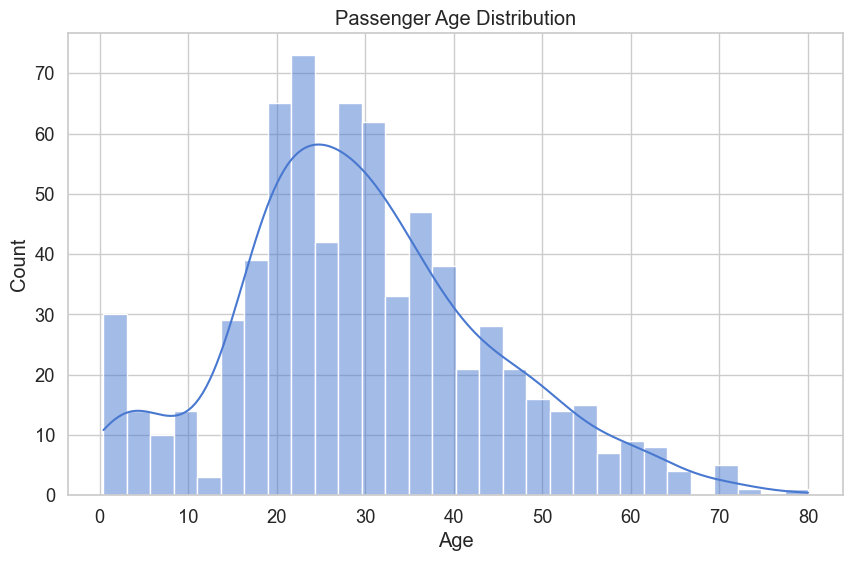

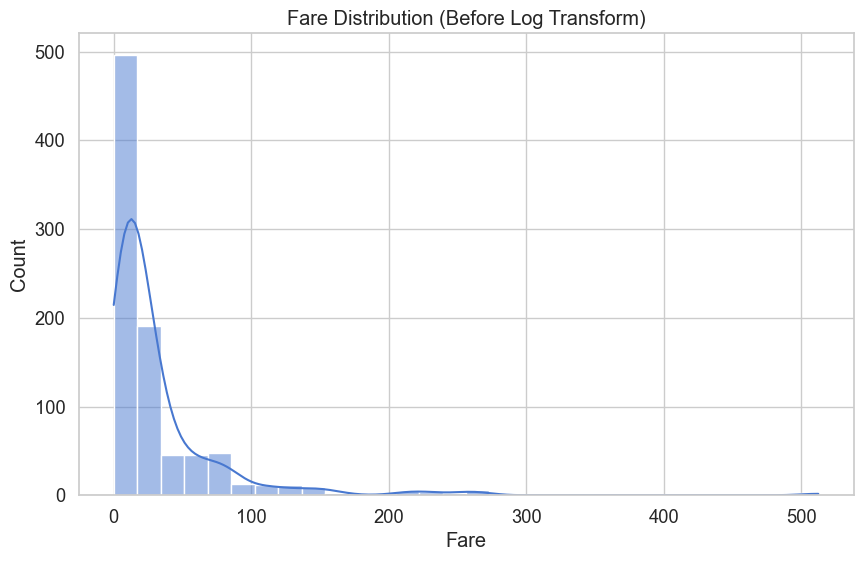

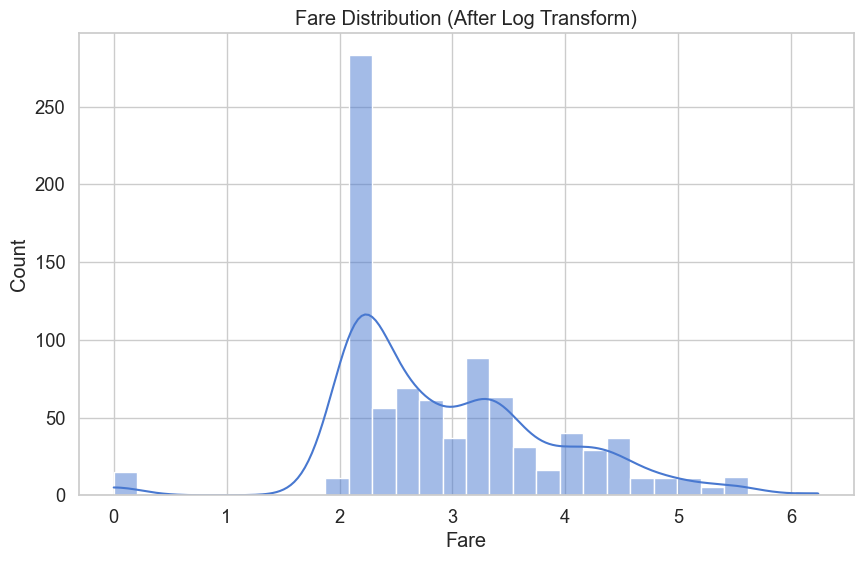

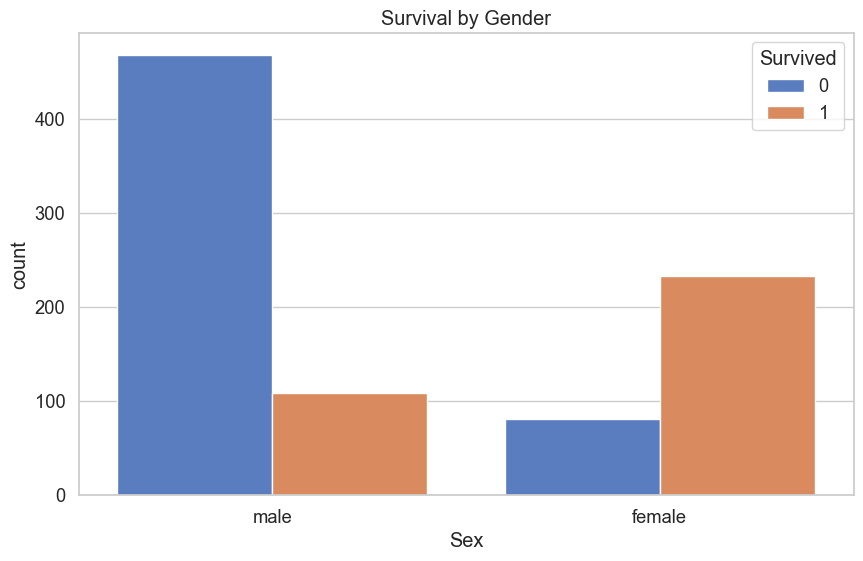

In [4]:
# Age distribution
plt.figure(figsize=(10,6))
sns.histplot(train['Age'].dropna(), kde=True, bins=30)
plt.title('Passenger Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Fare distribution before and after log transformation
plt.figure(figsize=(10,6))
sns.histplot(train['Fare'].dropna(), kde=True, bins=30)
plt.title('Fare Distribution (Before Log Transform)')
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(np.log1p(train['Fare'].dropna()), kde=True, bins=30)
plt.title('Fare Distribution (After Log Transform)')
plt.show()

# Count plot of gender and survival status
plt.figure(figsize=(10,6))
sns.countplot(x='Sex', hue='Survived', data=train)
plt.title('Survival by Gender')
plt.show()


## Feature Engineering
Perform feature extraction and transformation to improve the model's learning capability.

In [5]:
import re

def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return "None"

for dataset in [train, test]:
    # Extract Title from Name
    dataset['Title'] = dataset['Name'].apply(extract_title)

    # Group rare titles into 'Rare'
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                                 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Create FamilySize variable
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    # Process Cabin: extract the first character as Deck, assign 'U' (Unknown) if missing
    dataset['Deck'] = dataset['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')

    # Create isAlone variable: 1 if FamilySize = 1, otherwise 0
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    # Apply log transformation to Fare to handle outliers
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset['Fare_log'] = np.log1p(dataset['Fare'])

    # Fill missing Age values with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)

    # Fill missing Embarked values with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)


In [6]:
# Convert categorical variables to numerical
for dataset in [train, test]:
    # Gender variable: male -> 0, female -> 1
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1}).astype(int)

    # Embarked variable: S -> 0, C -> 1, Q -> 2
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Title variable: map titles to numerical values
    title_mapping = {title: idx for idx, title in enumerate(dataset['Title'].unique())}
    dataset['Title'] = dataset['Title'].map(title_mapping)

    # Deck variable: map characters to numerical values
    deck_mapping = {d: i for i, d in enumerate(sorted(dataset['Deck'].unique()))}
    dataset['Deck'] = dataset['Deck'].map(deck_mapping)

# Remove unnecessary columns
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

print('Preprocessing and feature engineering completed.')
train.head()


Preprocessing and feature engineering completed.


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,Deck,IsAlone,Fare_log
0,0,3,0,22.0,1,0,7.2500,0,0,2,8,0,2.110213
1,1,1,1,38.0,1,0,71.2833,1,1,2,2,0,4.280593
2,1,3,1,26.0,0,0,7.9250,0,2,1,8,1,2.188856
3,1,1,1,35.0,1,0,53.1000,0,1,2,2,0,3.990834
4,0,3,0,35.0,0,0,8.0500,0,0,1,8,1,2.202765


## Split Training and Internal Validation Data
Split the training data into training and validation sets to evaluate the model internally.

In [7]:
# Separate features and target variable
X = train.drop('Survived', axis=1)
y = train['Survived']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset sizes
print('Training set size:', X_train.shape, '| Validation set size:', X_val.shape)


Training set size: (712, 12) | Validation set size: (179, 12)


## Build Model and Hyperparameter Tuning
We will perform hyperparameter optimization for the Random Forest model and build additional models such as LightGBM, CatBoost, and XGBoost. After that, we will use Stacking Ensemble to combine their predictions for improved performance.

In [8]:
# Optimizing Random Forest with GridSearchCV
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print('Best parameters for Random Forest:', grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_val)
acc_rf = accuracy_score(y_val, y_pred_rf)
print('Random Forest accuracy after tuning:', acc_rf)

### 2.  Building Other Models

# LightGBM
# Check for missing values and duplicates
print("Number of missing values:", X_train.isnull().sum().sum())
print("Number of duplicate rows:", X_train.duplicated().sum())

# Remove duplicate rows if necessary
if X_train.duplicated().sum() > 0:
    X_train = X_train.drop_duplicates()
    y_train = y_train.loc[X_train.index]
    print("Duplicates removed. New training size:", X_train.shape[0])

# Define LightGBM model with optimized hyperparameters
lgbm = LGBMClassifier(
    n_estimators=500,         # More trees for better learning
    learning_rate=0.03,       # Lower learning rate for better generalization
    max_depth=-1,             # Allow deep trees
    num_leaves=31,            # Optimal leaf number for complexity control
    min_child_samples=5,      # Allow more splits
    min_split_gain=0,         # No minimum gain required to split
    colsample_bytree=0.8,     # Use 80% of features per tree
    subsample=0.8,            # Use 80% of data per boosting iteration
    subsample_freq=5,         # Enable subsampling every 5 iterations
    class_weight='balanced',  # Handle imbalanced datasets
    random_state=42,
    force_col_wise=True
)

# Train the model
lgbm.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_lgbm = lgbm.predict(X_val)

# Compute accuracy
acc_lgbm = accuracy_score(y_val, y_pred_lgbm)
print('LightGBM accuracy after duplicate removal:', acc_lgbm)

# CatBoost (with verbose=0 to reduce printed output)
catb = CatBoostClassifier(n_estimators=200, learning_rate=0.05, random_state=42, verbose=0)
catb.fit(X_train, y_train)
y_pred_catb = catb.predict(X_val)
acc_catb = accuracy_score(y_val, y_pred_catb)
print('CatBoost accuracy:', acc_catb)

# XGBoost
y_train = y_train.astype(int)
y_val = y_val.astype(int)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
acc_xgb = accuracy_score(y_val, y_pred_xgb)
print('XGBoost accuracy:', acc_xgb)


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest accuracy after tuning: 0.8435754189944135
Number of missing values: 0
Number of duplicate rows: 94
Duplicates removed. New training size: 618
[LightGBM] [Info] Number of positive: 250, number of negative: 368
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 618, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM accuracy after duplicate removal: 0.8212290502793296
CatBoost accuracy: 0.8212290502793296
XGBoost accuracy: 0.8156424581005587


### 3. Building Stacking Ensemble
Combine the base models built above using StackingClassifier from sklearn. The chosen meta-model here is Logistic Regression.

In [9]:
# List of base models for stacking
estimators = [
    ('rf', best_rf),
    ('lgbm', lgbm),
    ('catb', catb),
    ('xgb', xgb)
]

# Build StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# Train the stacking ensemble
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_val)
acc_stack = accuracy_score(y_val, y_pred_stack)
print('Stacking Ensemble accuracy:', acc_stack)


[LightGBM] [Info] Number of positive: 250, number of negative: 368
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 618, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 200, number of negative: 294
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 494, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 200, number of negative: 294
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 494, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of p

## Model Evaluation
Compare the accuracy of each individual model with the Stacking Ensemble. If a model achieves the desired accuracy on the validation set, it can be selected as the final model.

In [10]:
# Print the accuracy of the models
print('Random Forest:', acc_rf)
print('LightGBM:', acc_lgbm)
print('CatBoost:', acc_catb)
print('XGBoost:', acc_xgb)
print('Stacking Ensemble:', acc_stack)

Random Forest: 0.8435754189944135
LightGBM: 0.8212290502793296
CatBoost: 0.8212290502793296
XGBoost: 0.8156424581005587
Stacking Ensemble: 0.8212290502793296


## Train the Final Model and Make Predictions on the Test Set
Use the Stacking Ensemble (or the best-performing model) to train on the entire training dataset and make predictions on the test set, then generate the submission file.

In [11]:
# Train the stacking model on the entire training dataset
stacking_clf.fit(X, y)

# Predict on the test set
test_preds = stacking_clf.predict(test)

# Create the submission file
submission = pd.DataFrame({
    'PassengerId': pd.read_csv('test.csv')['PassengerId'],
    'Survived': test_preds
})
submission.to_csv('submission.csv', index=False)
print('The file submission.csv has been created.')


[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of pos